In [4]:
%matplotlib notebook  
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from helpers import conn, db_to_dataframe
from sklearn.preprocessing import StandardScaler
import talib

<IPython.core.display.Javascript object>


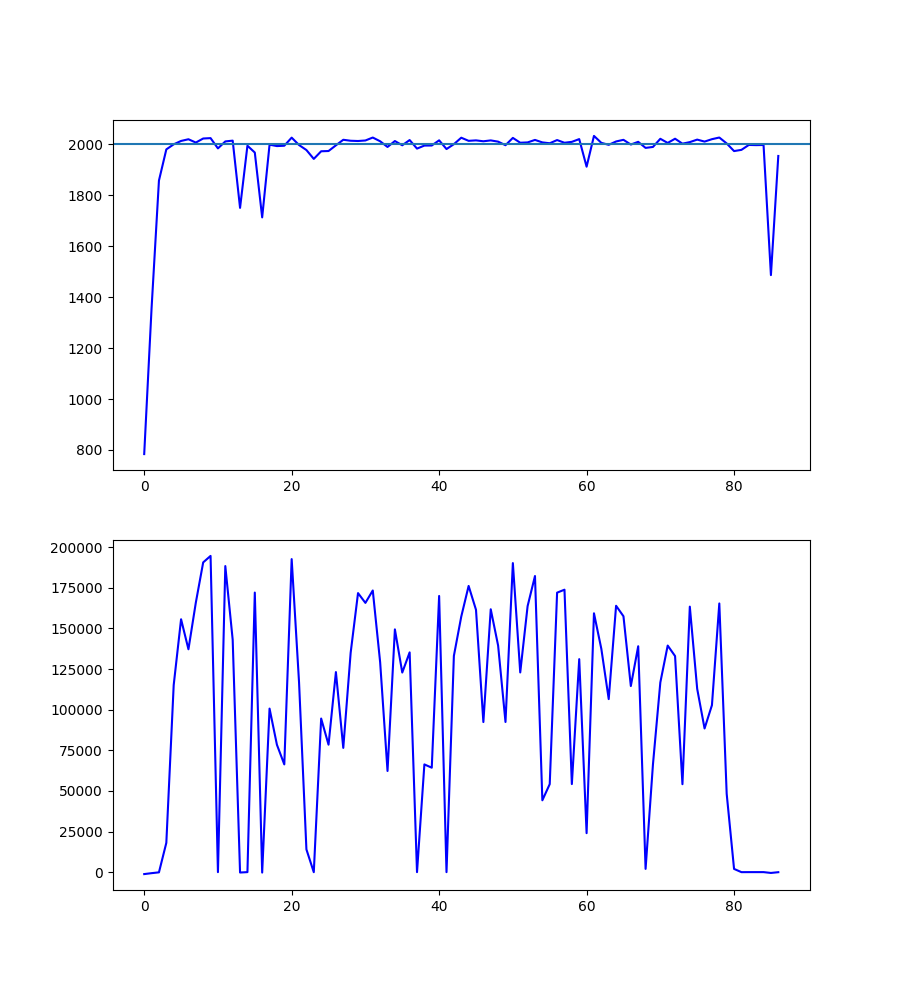

In [58]:
data = dict(
    b="A3C|VPG|L150L150",
    #r="A3C|VPG|L150L150|-indicators",
    #g="A3C|VPG|L150L150|adam",
)

queries = {}
for k, v in data.items():
    queries[k] = """
    select reward, cash+value as total 
    from episodes 
    where agent_name='{}' 
    order by episode asc
    --limit 300
    --offset 50
    """.format(v)

fig = plt.figure(figsize=(9,10))
ax_total = fig.add_subplot(211)
ax_reward = fig.add_subplot(212)
#plt.ion()

fig.show()
fig.canvas.draw()

def prep(arr, period=None):
    if not period: return arr
    #return arr[-limit:]
    return [np.mean(arr[i-period:i]) for i,v in enumerate(arr)]
    #return talib.SMA(arr.values, timeperiod=period)
    
def draw():
    dfs = {}
    for k, v in queries.items(): 
        dfs[k] = pd.read_sql_query(v, conn)
    ax_total.clear(); ax_reward.clear()
    rewards, totals = [], []
    for k, v in dfs.items():
        rewards += [prep(v['reward']), k]  # [arr, 'b']
        totals += [prep(v['total']), k]
    ax_reward.plot(*rewards)
    ax_total.plot(*totals)
    ax_total.axhline(y=2000)
    #ax_total.set_ylim([1800,2020])
    fig.canvas.draw()
    #ax_reward.set_ylim([-3000000,1000])
    
draw()
#while True:
#    draw()
#    time.sleep(10)

<IPython.core.display.Javascript object>


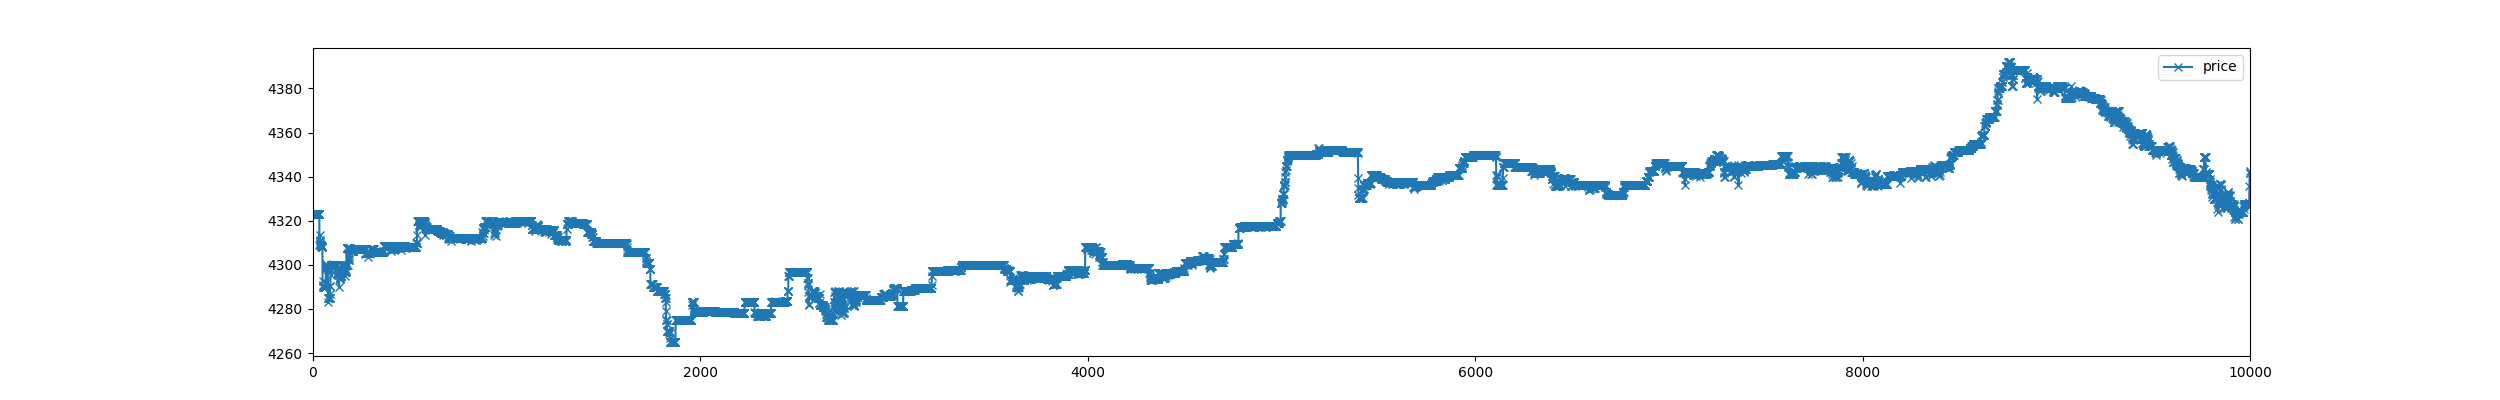

PNL:0.0


In [57]:
from tradingWithPython.lib.backtest import Backtest
rows = conn.execute("select y, signals from episodes where agent_name='A3C|VPG|L150L150' and signals is not null order by episode desc limit 1").fetchall()
y, signals = rows[0]
fig = plt.figure(figsize=(25, 4))
bt = Backtest(pd.Series(y), pd.Series(signals), signalType='capital')
bt.plotTrades()
print('PNL:{}'.format(bt.pnl.iloc[-1]))
plt.show()


In [98]:
df = db_to_dataframe(scaler=None, limit=1000)
y = df['gdax_btcusd_last'].values
diff = pd.Series(y).pct_change().replace([np.inf, -np.inf, np.nan], [0.9, -0.9, 0.]).values
print(len(y),len(diff))

scaler = StandardScaler()
scaled = scaler.fit_transform(pd.DataFrame(dict(y=y, diff=diff)))

plt.plot(scaled[0], 'g', scaled[1], 'b')
plt.show()


1000 1000
